# MLM Fine tuning (domain Adaption)

https://drive.google.com/drive/folders/1Q9prRy02buQ09X5RDia-KMO1G19qPwws?usp=sharing

### https://huggingface.co/course/chapter7/3?fw=pt

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import transformers
import torch
import pandas as pd
import datasets
import nltk
import sentence_transformers
import ast
import math
import matplotlib.pyplot as plt

C:\Users\Sridhar Kamoji\AppData\Roaming\Python\Python38\site-packages\huggingface_hub\snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


In [3]:
from transformers import AutoModelForMaskedLM, DistilBertConfig
from transformers import AutoTokenizer
import torch
import pandas as pd
import os
from datasets import Dataset, DatasetDict

### Load Pretrained Distilbert modes

In [4]:
model_checkpoint = "distilbert-base-uncased"
config = DistilBertConfig(output_hidden_states = True)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint, config = config)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

### Load Data

In [5]:
# Dataset Ref:
# https://huggingface.co/datasets/fabiochiu/medium-articles
data = datasets.load_dataset('fabiochiu/medium-articles', data_files= 'medium_articles.csv')

# converting the dataset_dictionary object to pandas dataframe
data = pd.DataFrame.from_dict(data['train'])

Using custom data configuration fabiochiu--medium-articles-96791ff68926910d
Reusing dataset csv (C:\Users\Sridhar Kamoji\.cache\huggingface\datasets\fabiochiu___csv\fabiochiu--medium-articles-96791ff68926910d\0.0.0\652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
data['tags'] = [ast.literal_eval(x) for x in data['tags']]
data['tags_joined'] = [', '.join(x) for x in data['tags']]

data['bert_text'] = data['title'] + '\n\n\n' + data['text'] + '\n\n\n' + 'This article belong to the following segments ' + data['tags_joined']

data['label'] = 0

data.dropna(inplace = True)
data.reset_index(drop = True, inplace = True)

In [7]:
data.shape

(192361, 9)

### Sample the data for fine tuning

In [8]:
train_df = data[['bert_text', 'label']].sample(n = 2000).copy()
train_dataset = Dataset.from_dict(train_df)

# converting into dataset object
bert_dataset = DatasetDict({'train': train_dataset})

In [9]:
bert_dataset

DatasetDict({
    train: Dataset({
        features: ['bert_text', 'label'],
        num_rows: 2000
    })
})

In [10]:
sample = bert_dataset["train"].shuffle(seed=42).select(range(3))

for row in sample:
    print(f"\n'>>> Review: {row['bert_text']}'")
    print(f"'>>> Label: {row['bert_text']}'")


'>>> Review: My Body — The Frenemy. Trigger Warning: Strong language, body…


Trigger Warning: Strong language, body dysmorphia, self harm, disordered eating, anxiety, depression

For most of my childhood I had no issues with my body. It looked fine, it worked fine, I didn’t think twice about it.

The first time I was forced to consider my physicality was at the end of college when my boyfriend at the time called me pleasantly plump. It was a shock to me, Ms. Effortlessly Skinny that I could ever be perceived as plump. Seeing myself in the mirror I wouldn’t have really considered myself fat. I saw myself as I always saw myself. A few extra stretch marks here and there, but the rest seemed fine.

It was only through other people’s eyes that I began to notice that I was fat. A few years later my brother also commented that I looked like a family friend of ours who had very big hips. I still couldn’t really wrap my head around it. But over time I started looking around and comparing with

### Tokenize the text 

In [10]:
def tokenize_function(examples):
    result = tokenizer(examples["bert_text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

# Use batched=True to activate fast multithreading!
tokenized_datasets = bert_dataset.map(
    tokenize_function, batched=True, remove_columns=["bert_text", "label"]
)
tokenized_datasets

  0%|          | 0/2 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1800 > 512). Running this sequence through the model will result in indexing errors


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 2000
    })
})

### Group and split the text

In [11]:
tokenizer.model_max_length

512

512 is too huge for the GPU, we'll go with the smaller number

In [12]:
chunk_size = 128

#### Before Chunking the texts

In [19]:
tokenized_samples = tokenized_datasets["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 1800'
'>>> Review 1 length: 1851'
'>>> Review 2 length: 875'


In [14]:
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated reviews length: {total_length}'")

'>>> Concatenated reviews length: 4526'


### After chunking

In [15]:
chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 80'


In [21]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [22]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 18321
    })
})

In [23]:
tokenizer.decode(lm_datasets["train"][900]["input_ids"])

'that should be closely emphasized ; loving mentions that the word “ mercy ” is not the one that is italicized in the first line for a reason — because it is not the prevailing sentiment. loving also brings attention to the duplicity “ benighted ” carries, and how it is a euphemism for ignorant yet literally translate to “ surrounded by darkness. ” the darkness, argues loving, is not her pre - christian existence ; it is her abduction from her homeland by slave traders. the emphasis on the word “ saviour ” highlights the distinction from god himself, and loving claims that this distinction is a satirical reference to'

In [24]:
tokenizer.decode(lm_datasets["train"][900]["labels"])

'that should be closely emphasized ; loving mentions that the word “ mercy ” is not the one that is italicized in the first line for a reason — because it is not the prevailing sentiment. loving also brings attention to the duplicity “ benighted ” carries, and how it is a euphemism for ignorant yet literally translate to “ surrounded by darkness. ” the darkness, argues loving, is not her pre - christian existence ; it is her abduction from her homeland by slave traders. the emphasis on the word “ saviour ” highlights the distinction from god himself, and loving claims that this distinction is a satirical reference to'

### Fine-tuning DistilBERT with the Huggingface Trainer API

In [25]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [26]:
samples = [lm_datasets["train"][i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] tag helpers in asp. net core mvc — sagar jaybhay asp pageuria helper / [MASK] helpers in [MASK] [MASK]. net core mvc [MASK] [MASK] new in asp. [MASK] core. these are a server - side component. it is processed on the server and renders an html element in razor files. it is similar [MASK] html help [MASK] there are so many [MASK] helpers like generating the link, creating forms, etc, to use tag helper we need to import these tag helper first. for example, we need to create anchor [MASK] [MASK] with the help of tag helper < a'

'>>> asp - controller = " duncan " asp - [MASK] = " details " asp - route - id = " @ stud. studentid " > details < / a > in this asp - controller = is took controller name is took controller name asp - action [MASK] is the action or [MASK] name present in that controller is the action [MASK] method name present in that controller asp [MASK] route [MASK] id = is the parameter we pass to that method [MASK] you can see if we use packed - helper the [MASK] 

### Whole Word Masking

In [28]:
import collections
import numpy as np

from transformers import default_data_collator

wwm_probability = 0.2


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id

    return default_data_collator(features)

In [29]:
samples = [lm_datasets["train"][i] for i in range(2)]
batch = whole_word_masking_data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] tag helpers in asp. net [MASK] mvc — sagar jaybhay [MASK] [MASK] page [MASK] helper [MASK] tag helpers [MASK] asp. net [MASK] mvc this is new in asp. net [MASK]. these are [MASK] server - side component. it is processed on [MASK] server and renders an [MASK] element in [MASK] files. it is similar to html helpers [MASK] are so many tag [MASK] [MASK] like generating the link [MASK] creating forms, etc, to use tag helper [MASK] [MASK] [MASK] import these tag helper first. for example, we need to create anchor a tag with the help of [MASK] [MASK] [MASK] < a'

'>>> asp [MASK] [MASK] = " home " [MASK] [MASK] - [MASK] = [MASK] details " [MASK] [MASK] - route - [MASK] = " @ stud. [MASK] [MASK] " > [MASK] < [MASK] a > in this [MASK] [MASK] - controller = is took controller name is took controller name asp [MASK] action = is the action or method name present in that controller is the action or [MASK] [MASK] present in that controller asp - [MASK] - id [MASK] is the parameter [MASK] [

In [30]:
train_size = int(lm_datasets["train"].shape[0]/1.1)
test_size = int(0.1 * train_size)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)


print(lm_datasets["train"].shape[0])
downsampled_dataset

18321


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 16655
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1665
    })
})

In [25]:
downsampled_dataset.save_to_disk('MediumArticlesDataSet4MLMTraining')

Flattening the indices:   0%|          | 0/17 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/2 [00:00<?, ?ba/s]

In [36]:
DatasetDict.load_from_disk('MediumArticlesDataSet4MLMTraining')

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 16034
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1603
    })
})

In [32]:
from transformers import TrainingArguments

batch_size = 32
# Show the training loss with every epoch
logging_steps = len(downsampled_dataset["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-MediumArticlesMLM",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=False,
    fp16=True,
    logging_steps=logging_steps,
    num_train_epochs = 50,
    load_best_model_at_end=True,
    save_strategy= 'epoch',
    metric_for_best_model = 'eval_loss',
    greater_is_better = False
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [33]:
from transformers import Trainer, EarlyStoppingCallback, IntervalStrategy

In [39]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=data_collator,
)

Using cuda_amp half precision backend


In [40]:
import math

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1603
  Batch size = 32


>>> Perplexity: 27.09


In [41]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 16034
  Num Epochs = 50
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 25100


Epoch,Training Loss,Validation Loss
1,2.751600,2.542353
2,2.612900,2.505242
3,2.562500,2.452511
4,2.516400,2.437785
5,2.477500,2.405717
6,2.445700,2.419353
7,2.426400,2.376204
8,2.408300,2.344040
9,2.380200,2.379923
10,2.354000,2.394961


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1603
  Batch size = 32
Saving model checkpoint to distilbert-base-uncased-MediumArticlesMLM\checkpoint-502
Configuration saved in distilbert-base-uncased-MediumArticlesMLM\checkpoint-502\config.json
Model weights saved in distilbert-base-uncased-MediumArticlesMLM\checkpoint-502\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1603
  Batch size = 32
Saving model checkpoint to distilbert-base-uncased-MediumArticlesMLM\checkpoint-1004

Model weights saved in distilbert-base-uncased-MediumArticlesMLM\checkpoint-7028\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1603
  Batch size = 32
Saving model checkpoint to distilbert-base-uncased-MediumArticlesMLM\checkpoint-7530
Configuration saved in distilbert-base-uncased-MediumArticlesMLM\checkpoint-7530\config.json
Model weights saved in distilbert-base-uncased-MediumArticlesMLM\checkpoint-7530\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1603


  Batch size = 32
Saving model checkpoint to distilbert-base-uncased-MediumArticlesMLM\checkpoint-14056
Configuration saved in distilbert-base-uncased-MediumArticlesMLM\checkpoint-14056\config.json
Model weights saved in distilbert-base-uncased-MediumArticlesMLM\checkpoint-14056\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1603
  Batch size = 32
Saving model checkpoint to distilbert-base-uncased-MediumArticlesMLM\checkpoint-14558
Configuration saved in distilbert-base-uncased-MediumArticlesMLM\checkpoint-14558\config.json
Model weights saved in distilbert-base-uncased-MediumArticlesMLM\checkpoint-14558\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMask

***** Running Evaluation *****
  Num examples = 1603
  Batch size = 32
Saving model checkpoint to distilbert-base-uncased-MediumArticlesMLM\checkpoint-21084
Configuration saved in distilbert-base-uncased-MediumArticlesMLM\checkpoint-21084\config.json
Model weights saved in distilbert-base-uncased-MediumArticlesMLM\checkpoint-21084\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1603
  Batch size = 32
Saving model checkpoint to distilbert-base-uncased-MediumArticlesMLM\checkpoint-21586
Configuration saved in distilbert-base-uncased-MediumArticlesMLM\checkpoint-21586\config.json
Model weights saved in distilbert-base-uncased-MediumArticlesMLM\checkpoint-21586\pytorch_model.bin
The following columns in the evaluation set don'

TrainOutput(global_step=25100, training_loss=2.2097839118379996, metrics={'train_runtime': 5818.4349, 'train_samples_per_second': 137.786, 'train_steps_per_second': 4.314, 'total_flos': 2.65685697105408e+16, 'train_loss': 2.2097839118379996, 'epoch': 50.0})

In [43]:
trainer.state.best_metric
trainer.state.best_model_checkpoint
trainer.state.log_history

2.2188620567321777

'distilbert-base-uncased-MediumArticlesMLM\\checkpoint-24096'

[{'loss': 2.7516,
  'learning_rate': 1.9602390438247013e-05,
  'epoch': 1.0,
  'step': 501},
 {'eval_loss': 2.5423526763916016,
  'eval_runtime': 2.2961,
  'eval_samples_per_second': 698.147,
  'eval_steps_per_second': 22.212,
  'epoch': 1.0,
  'step': 502},
 {'loss': 2.6129,
  'learning_rate': 1.920318725099602e-05,
  'epoch': 2.0,
  'step': 1002},
 {'eval_loss': 2.505242347717285,
  'eval_runtime': 2.7092,
  'eval_samples_per_second': 591.678,
  'eval_steps_per_second': 18.824,
  'epoch': 2.0,
  'step': 1004},
 {'loss': 2.5625,
  'learning_rate': 1.880398406374502e-05,
  'epoch': 2.99,
  'step': 1503},
 {'eval_loss': 2.4525105953216553,
  'eval_runtime': 2.9555,
  'eval_samples_per_second': 542.387,
  'eval_steps_per_second': 17.256,
  'epoch': 3.0,
  'step': 1506},
 {'loss': 2.5164,
  'learning_rate': 1.8404780876494026e-05,
  'epoch': 3.99,
  'step': 2004},
 {'eval_loss': 2.4377851486206055,
  'eval_runtime': 2.9322,
  'eval_samples_per_second': 546.693,
  'eval_steps_per_second': 

In [46]:
history = pd.DataFrame(trainer.state.log_history).groupby(['epoch'])['loss', 'eval_loss'].sum()

history.reset_index(drop = False, inplace = True)

history['epoch_int'] = [math.ceil(x) for x in history['epoch']]

history = history.groupby('epoch_int')['loss', 'eval_loss'].sum()

Text(0.5, 1.0, 'MLM Finetuning')

Text(0.5, 0, 'Epochs==>')

Text(0, 0.5, 'Loss==>')

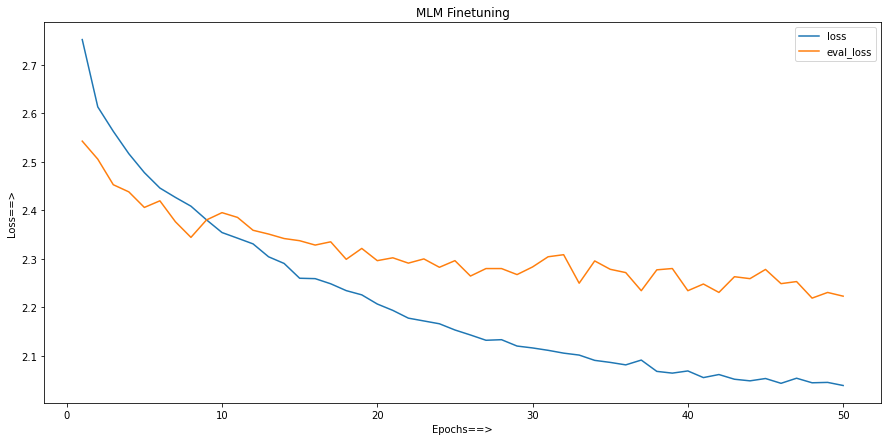

In [53]:
history.plot(figsize = (15,7))
plt.title('MLM Finetuning')
plt.xlabel('Epochs==>')
plt.ylabel('Loss==>')
plt.savefig('DBert_TrainValLoss.png')

In [54]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1603
  Batch size = 32


>>> Perplexity: 9.33


In [55]:
model.save_pretrained('./MediumArticlesDbertFineTuned')

Configuration saved in ./MediumArticlesDbertFineTuned\config.json
Model weights saved in ./MediumArticlesDbertFineTuned\pytorch_model.bin


In [8]:
tokenizer.save_pretrained('MediumArticlesDbertTokenizer')

('MediumArticlesDbertTokenizer\\tokenizer_config.json',
 'MediumArticlesDbertTokenizer\\special_tokens_map.json',
 'MediumArticlesDbertTokenizer\\vocab.txt',
 'MediumArticlesDbertTokenizer\\added_tokens.json',
 'MediumArticlesDbertTokenizer\\tokenizer.json')

### Load the finetuned model

In [9]:
model_checkpoint = "MediumArticlesDbertFineTuned"
tokenizer_chkpt = 'MediumArticlesDbertTokenizer'
config = DistilBertConfig(output_hidden_states = True)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint, config = config)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_chkpt)

In [38]:
# txt = 'hello world'
txt = 'I have two cats which are extremely naughty!'
ip = tokenizer(txt, return_tensors= 'pt')
print(ip)
op = model(ip['input_ids'], ip['attention_mask'])

{'input_ids': tensor([[  101,  1045,  2031,  2048,  8870,  2029,  2024,  5186, 20355,   999,
           102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [19]:
txt = 'I have two cats which are extremely naughty!'
# txt = 'hello world'
enc = tokenizer.encode(txt)
dec = tokenizer.decode(enc)

[(enc_, dec_) for (enc_,dec_) in zip(enc,dec.split())]

[(101, '[CLS]'),
 (1045, 'i'),
 (2031, 'have'),
 (2048, 'two'),
 (8870, 'cats'),
 (2029, 'which'),
 (2024, 'are'),
 (5186, 'extremely'),
 (20355, 'naughty!'),
 (999, '[SEP]')]

In [71]:
txt_lst = ['hello world', 
           'I have two cats which are extremely naughty!']
ip = tokenizer(txt_lst, max_length= 32, padding= 'max_length', return_tensors= 'pt')

In [72]:
ip

{'input_ids': tensor([[  101,  7592,  2088,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  1045,  2031,  2048,  8870,  2029,  2024,  5186, 20355,   999,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

In [73]:
op = model(ip['input_ids'], ip['attention_mask'])

In [83]:
# txt = 'hello world'
txt = 'I have two cats which are extremely naughty!'
ip = tokenizer(txt, return_tensors= 'pt')
print(ip)
op = model(ip['input_ids'], ip['attention_mask'])

{'input_ids': tensor([[  101,  1045,  2031,  2048,  8870,  2029,  2024,  5186, 20355,   999,
           102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [84]:
len(op.hidden_states)

7

In [85]:
op.hidden_states[0].shape
op.hidden_states[0]

torch.Size([1, 11, 768])

tensor([[[ 0.3515, -0.1593, -0.2332,  ...,  0.1622,  0.1203,  0.0880],
         [ 0.2737,  0.3202, -0.5646,  ...,  0.4563,  0.9332,  0.3527],
         [-0.2009,  0.3250,  0.4047,  ...,  0.6116, -1.2480, -0.5579],
         ...,
         [ 0.0644, -0.0431,  0.4693,  ..., -0.3132, -0.2309, -0.7068],
         [ 1.1086, -0.1345, -0.8389,  ...,  0.3473,  0.2417,  0.4418],
         [-0.3996, -0.0612, -0.2939,  ...,  0.0884,  0.5354,  0.0552]]],
       grad_fn=<NativeLayerNormBackward0>)

### Getting Sentence Embeddings

In [86]:
def SentenceEmbeddings(text: str = None, model = None , tokenizer=None, num_hidden_states: int = None):
    '''
    calculate the mean sentence embeddings of text from bert model.
    Args:
        param: text: string : the text that needs to be featurized
        param: model: transformers.models: Bert model that takes Pytorch input
        param: tokenizer: tokenizer that takes text as input and outputs input_ids and attention_mask torch tensors
        param: num_hidden_states: int: number of hidden states to consider while for horizontal stack
    
    return type: Torch Tensor
    
    '''
    
    if num_hidden_states is None:
        print("num_hidden_states is none!!! hence using last layer")
        num_hidden_states = 1
        
    if text is None or "":
        raise ValueError("text cannot be None or empty string")
    
    if model is None or tokenizer is None:
        raise ValueError("Please Specify model and tokenizer properly")
    
    if num_hidden_states > model.config.n_layers:
        print('Number of hidden layers in model are {0}, but specified layers to consider are {1}'.format(model.config.n_layers, num_hidden_states))
        print('Using all the layers to get Sentence Embeddings')
    
    # tokenize the text
    ip = tokenizer(text, return_tensors = 'pt', truncation = True)
    # get the model output
    op = model(**ip)
    #get hidden stated
    hs = op['hidden_states'][-1*num_hidden_states:]
    # stack the vectors horizontally
    stack_vec= torch.hstack([vec[0] for vec in hs])
    #get the mean embeddings
    mean_vec = torch.mean(stack_vec, dim = 0)
    
    return mean_vec

In [88]:
emb = SentenceEmbeddings('RVCE is one of the top college in karnataka', model, tokenizer, 2)

In [93]:
emb.reshape((1,-1)).shape

torch.Size([1, 1536])

### Pipeline usage

In [95]:
from transformers import pipeline

In [96]:
pipe = pipeline(task= 'fill-mask', model=model, tokenizer=tokenizer)
# fill mask is used for auto correct / auto suggestions etc

In [98]:
pipe('the fullform of NLP is natural [MASK] processing')

[{'score': 0.7424009442329407,
  'token': 2653,
  'token_str': 'language',
  'sequence': 'the fullform of nlp is natural language processing'},
 {'score': 0.0478600338101387,
  'token': 3224,
  'token_str': 'forest',
  'sequence': 'the fullform of nlp is natural forest processing'},
 {'score': 0.02924789860844612,
  'token': 4742,
  'token_str': 'signal',
  'sequence': 'the fullform of nlp is natural signal processing'},
 {'score': 0.021199537441134453,
  'token': 3746,
  'token_str': 'image',
  'sequence': 'the fullform of nlp is natural image processing'},
 {'score': 0.008734915405511856,
  'token': 1011,
  'token_str': '-',
  'sequence': 'the fullform of nlp is natural - processing'}]

In [102]:
pipe('the fullform of NLP is natural language [MASK]')

[{'score': 0.3084496259689331,
  'token': 6364,
  'token_str': 'processing',
  'sequence': 'the fullform of nlp is natural language processing'},
 {'score': 0.2286016196012497,
  'token': 1012,
  'token_str': '.',
  'sequence': 'the fullform of nlp is natural language.'},
 {'score': 0.03698771819472313,
  'token': 4083,
  'token_str': 'learning',
  'sequence': 'the fullform of nlp is natural language learning'},
 {'score': 0.03688197582960129,
  'token': 2069,
  'token_str': 'only',
  'sequence': 'the fullform of nlp is natural language only'},
 {'score': 0.021707097068428993,
  'token': 2671,
  'token_str': 'science',
  'sequence': 'the fullform of nlp is natural language science'}]